# Lexical Predictability

This code aims to calculate the lexical predictability of disordered text from local to global using GPT2 model and analyze the effect of disorder level and context length on predictability.

## 1. Disordered text
generate 600 samples: disorder level 10%-60%, 100 samples for each level


In [ ]:
import requests
from bs4 import BeautifulSoup
import codecs
import random
from tqdm import tqdm
import csv
import os

### download and preprocess the text sample

In [2]:
## download text file from url

url = "https://www.gutenberg.org/files/1228/1228-h/1228-h.htm"
save_path = "origin_of_species.txt"

# Send a GET request to the URL
response = requests.get(url)

# parse the HTML content
soup = BeautifulSoup(response.content, "html.parser")

# Extract the plain text content
text = soup.get_text()

# save to a txt file
with open(save_path, "w", encoding="utf-8") as file:
    file.write(text)

print("downloaded successfully!")

downloaded successfully!


In [4]:
## clean the text

bookfile=save_path
with codecs.open(bookfile, encoding="utf8") as f:
    book=f.read()
end_word = "evolved"
end_index = book.find(end_word)+len(end_word)
book=book[: end_index].replace("\r", "")
book = re.sub(r'(?<!\n)\n(?!\n)', ' ', book)
book = re.sub(r'\n+', '\n', book)
chapters_num = 15
pattern = re.compile(r'^(INTRODUCTION|CHAPTER)', re.MULTILINE)
chapters= re.split(pattern, book)[-chapters_num*2+1::2]
chapters

### random select and shuffle

In [65]:
# randomly select one chapter
chapt_id = random.randint(0,len(chapters)-1)
sample = chapters[chapt_id]

In [87]:
# Create list of words' indices
words = paragraphs[4].split()
words_ids = [i for i in range(len(words))]

# Define number of words to shuffle according to disorder_level proportion
disorder_level = 0.2
k_2shuffle = int(disorder_level * len(words))

# Sample disorder_level proportion of indices to shuffle within total indices list, and shuffle them
words_ids_sampled = random.sample(population=words_ids, k=k_2shuffle)
len(words_ids_sampled)

41

In [89]:
print(words_ids_sampled)
random.shuffle(words_ids_sampled)
print(words_ids_sampled)


# Get sampled indices in order, to fill positions one by one
words_ids_sampled_sorted = sorted(words_ids_sampled)
print(words_ids_sampled_sorted)


[114, 41, 174, 11, 143, 155, 47, 111, 184, 129, 124, 196, 49, 12, 150, 123, 138, 18, 6, 21, 127, 120, 28, 22, 158, 56, 67, 161, 125, 180, 4, 26, 64, 69, 173, 197, 146, 151, 148, 157, 95]
[150, 138, 41, 127, 28, 123, 26, 143, 180, 151, 6, 120, 64, 95, 155, 173, 21, 197, 157, 114, 161, 56, 111, 174, 184, 125, 47, 12, 148, 4, 49, 196, 69, 67, 11, 129, 124, 146, 158, 18, 22]
[4, 6, 11, 12, 18, 21, 22, 26, 28, 41, 47, 49, 56, 64, 67, 69, 95, 111, 114, 120, 123, 124, 125, 127, 129, 138, 143, 146, 148, 150, 151, 155, 157, 158, 161, 173, 174, 180, 184, 196, 197]


In [90]:

# Create copy of initial words to be modified
words_sample_shuffled = words[:]

# Insert shuffled words at positions of unshuffled sampled indices
for w_sampled_shuffled, w_sampled_sorted in zip (words_ids_sampled, words_ids_sampled_sorted):
    words_sample_shuffled[w_sampled_sorted] = words[w_sampled_shuffled]

In [91]:
# Join words with new order into a sentence again
sample_shuffled = ' '.join(words_sample_shuffled)

In [92]:
print(sample_shuffled)
print(paragraphs[4])

We shall best understand a probable shown of natural selection by become the case of a country undergoing of physical change, be proportional of climate. The the numbers be its inhabitants would almost immediately undergo a change, and some species might country extinct. We may conclude, from course we inhabitants. seen of the intimate and complex are in which the inhabitants of each country the bound together, barriers, any the in the numerical proportions of some of the inhabitants, independently of the change of climate itself, would most seriously affect many of the others. If for country were open on its borders, new forms would certainly immigrate, and this also would the disturb the which of some of the former relations Let it adapted manner seriously powerful economy influence if a single introduced tree or mammal has been how to be. But in what case of the island, or of the have partly surrounded by had into change that and better taking forms could not freely enter, we should

In [93]:
disorder_levels = [round(i/10, 1) for i in range(1,7)]
disorder_levels

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

In [103]:
from tqdm import tqdm

n_k=100
dataset = []
for level in tqdm(disorder_levels):
    k_2shuffle = int(disorder_level * len(words))

    for i in tqdm(range(n_k)):
        # Sample disorder_level proportion of indices to shuffle within total indices list, and shuffle them
        words_ids_sampled = random.sample(population=words_ids, k=k_2shuffle)
        # Get sampled indices in order, to fill positions one by one
        words_ids_sampled_sorted = sorted(words_ids_sampled)
        # Create copy of initial words to be modified
        words_sample_shuffled = words[:]

        # Insert shuffled words at positions of unshuffled sampled indices
        for w_sampled_shuffled, w_sampled_sorted in zip (words_ids_sampled, words_ids_sampled_sorted):
            words_sample_shuffled[w_sampled_sorted] = words[w_sampled_shuffled]
        
        # Join words with new order into a sentence again
        sample_shuffled = ' '.join(words_sample_shuffled)
        dataset.append({
                "disorder_level": level,
                "sample_id": i,
                "text_original": paragraphs[4],
                "text_shuffled": sample_shuffled
                    })


100%|██████████| 6/6 [00:00<00:00, 30.12it/s]


In [104]:

data_path="text_samples"
with open("paragraph_100samples.csv", 'w', encoding='utf-8', newline='') as data_file:
    writer = csv.DictWriter(data_file, fieldnames=dataset[0].keys())
    writer.writeheader()
    writer.writerows(dataset)

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')
text_obj = nlp(text_sample)

In [ ]:
print("Noun phrases:", [chunk.text for chunk in text_obj.noun_chunks])
print("Verbs:", [token.lemma_ for token in text_obj if token.pos_ == "VERB"])

Noun phrases: ['the distribution', 'organic beings', 'the face', 'the globe', 'the first great fact', 'which', 'us', 'neither the similarity', 'the dissimilarity', 'the inhabitants', 'various regions', 'their climatal and other physical conditions', 'almost every author', 'who', 'the subject', 'this conclusion', 'The case', 'America', 'its truth', 'we', 'the northern parts', 'the circumpolar land', 'all authors', 'the most fundamental divisions', 'geographical distribution', 'the New and Old Worlds', 'we', 'the vast American continent', 'the central parts', 'the United States', 'its extreme southern point', 'we', 'the most diversified conditions', 'almost every temperature', 'a climate', 'condition', 'the Old World', 'which', 'the New', 'the same species', 'it', 'a most rare case', 'a group', 'organisms', 'any small spot', 'conditions', 'only a slight degree', 'instance', 'small areas', 'the Old World', 'any', 'the New World', 'these', 'a peculiar fauna', 'flora', 'this parallelism', '

In [ ]:
for token in text_obj:
    print (type(token.text))
    print(token.text)

In [ ]:
words_all = [token.text for token in text_obj]

input and output
when shuffle:
when predict:

## 2. Word-by-word predictability

In [ ]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from tqdm import tqdm
import pandas as pd
import os


In [ ]:
# Load to GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')

# Load the GPT-2 model and tokenizer
model_name = 'gpt2'  # or 'gpt2-medium', 'gpt2-large', etc.
model = GPT2LMHeadModel.from_pretrained(model_name).to(device)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

# Set the model to evaluation mode
model.eval()

In [7]:
# read data
file='Chapter4_100samples.csv'
data = pd.read_csv(file)

In [ ]:
def word_by_word_predictability(sample):
    lexical_preds=[]
    
    encoded_sample=tokenizer.encode(sample['sample_shuffled'], return_tensors='pt').to(device)
    encoded_sample_lst = encoded_sample.tolist()[0]
    
    for word_position, word in enumerate(encoded_sample_lst):
        if word_position >= 64:
   
            for context_length in [1,2,4,8,16,32, 64]: #set the context length

                context = encoded_sample[:, word_position - context_length:word_position]

                # Generate predictions for the next word
                with torch.no_grad():
                    outputs = model(context)

                # Extract the predicted logits for the next word
                logits = outputs.logits[0, -1, :]

                # Compute the probabilities using softmax
                probabilities = torch.softmax(logits, dim=0)

                # Compute the probabilities using softmax
                preds = torch.softmax(outputs.logits, dim=-1)
                next_word_prob = preds[:, -1, word].item()

                lexical_preds.append({
                    "disorder_level": sample['disorder_level'],
                    "text": sample['sample_shuffled'],
                    "sample_id": sample['sample_id'],
                    "word": tokenizer.decode([word]),
                    "word_pos": word_position,
                    "context_length": context_length,
                    "context": tokenizer.decode(context[0]),
                    "predictability": next_word_prob
                    })

    
    return lexical_preds
    

In [ ]:
# Compute predictability for all samples

lexical=[]
for level in data.disorder_level.unique():
    preds = []

    print(f"Disorder level: {level}%")
    data_level = data[data['disorder_level'] == level]

    for sample_id, sample in tqdm(data_level.iterrows(), total=len(data_level), leave=False, position=0):
        # Get word-by-word predictability scores, varying context length for each word, for given sample
        preds_sample = word_by_word_predictability(sample)
        preds.extend(preds_sample)

        # Clear memory before next loop
        del preds_sample

    # Convert data to DataFrame
    preds = pd.DataFrame(preds)
    
    lexical.append(preds)
    # Save preds
    preds_file = f"results_level{level}.csv"
    preds.to_csv(preds_file, index=False)


## 3. Result analysis

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import quad

In [464]:
# Read data
def read_pred_files(files_path):
    # Name the predictability results files start with

    # Create list to append DataFrames to
    dfs = []

    # Select and read pickle files, convert to DataFrame
    for file in os.listdir(files_path):
        if file.startswith('results_level'):
            dfs.append(pd.read_csv(os.path.join(files_path, file)))

    # Concatenate data together and return
    return pd.concat(dfs, axis=0, ignore_index=True)

In [162]:
files_path = os.getcwd()
df_preds = read_pred_files(files_path)

### visualize overall data

In [ ]:
# lineplot

fig, ax = plt.subplots(layout='constrained', figsize=(7,5))
sns.lineplot(ax=ax, data=df_preds, hue='disorder_level', x='context_length', y='predictability', errorbar='se', palette='muted')
plt.xlabel('Context length')
plt.ylabel('Lexical predictability')
plt.title('Predictability under Context Length by Disorder Level')
plt.legend([], [], frameon=False)
fig.legend(loc='outside center right', title='Disorder level (%)')


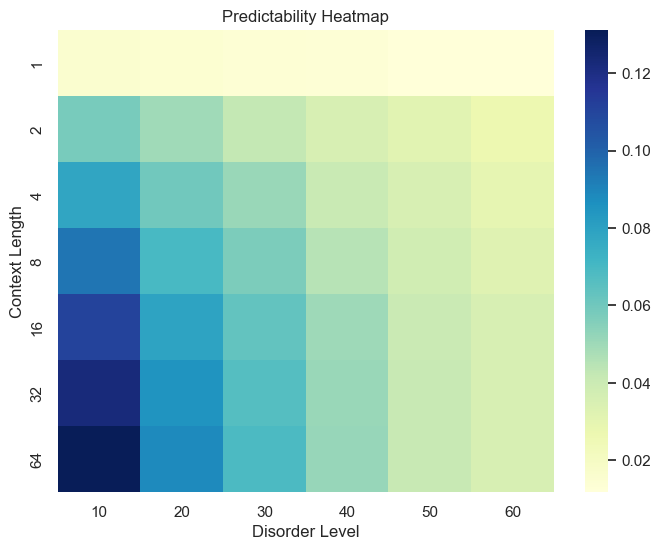

In [215]:
# heatmap
pivot_table = df_preds.pivot_table(values='predictability', index='context_length', columns='disorder_level')
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, cmap='YlGnBu')
plt.xlabel('Disorder Level')
plt.ylabel('Context Length')
plt.title('Predictability Heatmap')
plt.show()

### Model fit

In [300]:
df_agg = df_preds.groupby(['disorder_level', 'context_length'])['predictability'].mean().reset_index()

In [280]:
def fit(df, func):
    params=[]
    for level in df.disorder_level.unique():
        df_level = df[df['disorder_level'] == level]
        x = df_level['context_length'] 
        y = df_level['predictability']  
        params_level, _ = curve_fit(func, x, y)

        y_predicted = func(x, *params_level)
        r_2 = 1 - (np.sum((y - y_predicted) ** 2) / np.sum((y - np.mean(y)) ** 2))

        params.append({
            'disorder_level': level,
            'params': params_level,
            'R_2': r_2
        })
        
    return params

In [335]:
def plot_fit(df, params,  func, save=False):
    fig, axs = plt.subplots(2, 3, sharey=True, sharex=True, figsize=(25,10))
    for i, level in enumerate(df.disorder_level.unique()):
        df_level = df[df['disorder_level'] == level]
        params_level = params[i]['params']

        axs.ravel()[i].plot(df_level['context_length'], func(df_level['context_length'], *params_level), '--', color='red', label='Fitted')
        axs.ravel()[i].plot(df_level['context_length'], df_level['predictability'], 'ro', color='blue', label='Measured')
        axs.ravel()[i].set_title(f"Disorder level: {level}% \n ({', '.join(['='.join(map(str, i)) for i in zip(['a', 'b', 'c', 'd'], [f'{p:0.4f}' for p in params_level])])})")
        # Compute r2
        r2 = params[i]['R_2']
        axs.ravel()[i].text(0.1, 0.9, f"R^2={r2:.2f}", fontsize=20, transform=axs.ravel()[i].transAxes, va='top')

    fig.supxlabel("Context length")
    fig.supylabel("Predictability")

    axs.ravel()[-1].legend()
    plt.tight_layout()


    if save:
        plt.savefig("plot_fit.png", dpi=600, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

In [474]:
def plot_growth(df, func):
    x=df['disorder_level']
    y=df['growth']
    
    fit_params, _ = curve_fit(func, x, y, maxfev=2000)

    y_predicted = func(x, *fit_params)
    r_2 = 1 - (np.sum((y - y_predicted) ** 2) / np.sum((y - np.mean(y)) ** 2))

    plt.plot(x, func(x, *fit_params), '--',
                            label='Fitted')
    plt.plot(x, y, 'ro', label=f'Measured')

    plt.xlabel("Disorder level (%)")
    plt.ylabel("Integral")
    plt.xticks(ticks=x)
    plt.text(0.7, 0.8, f"R^2={r_2:.2f}", fontsize=20, transform=plt.gca().transAxes, va='top')
    plt.legend()
    plt.title(
        f"{', '.join(['='.join(map(str, i)) for i in zip(['a', 'b', 'c'], [f'{p:0.4f}' for p in fit_params])])}")
    plt.show()

#### linear_model

In [269]:
def linear_func(x, a, b):
    return a*x+b

In [332]:
params_lin=fit(df_agg, linear_func)
plot_fit(df_agg, params_lin, linear_func)

#### log model

In [444]:
# log fit
def log_func(x, a, b, c):
    return a * np.log(b*x+c)

params_log=fit(df_agg, log_func)
plot_fit(df_agg, params_log, log_func)

In [447]:
# log integral
def log_integral(x, a, b, c):
    integrand = lambda x: a * np.log(b * x + c)
    integral, error = quad(integrand, x[0], x[-1])
    return integral
    
x=df_agg.context_length.sort_values().unique()
for p in params_log:
    a, b, c=p['params']
    p['growth']=log_integral(x, a, b, c)
    
params_log=pd.DataFrame(params_log)
plot_growth(params_log, exp_func)

#### Exp_model

In [ ]:
# exp_fit
def exp_func(x, a, b, c):
    return a*np.exp(-b*x) +c

params_exp=fit(df_agg, exp_func)
plot_fit(df_agg, params_exp, exp_func)

In [421]:
# exp integral
def exp_integral(x, a, b, c):
    integrand = lambda x: a * np.exp(-b * x) + c
    integral, error = quad(integrand, x[0], x[-1])
    return integral

x=df_agg.context_length.sort_values().unique()
for p in params_exp:
    # 0: a, 1: b, 2: c
    # Integrate
    a, b, c=p['params']
    p['growth']=exp_integral(x, a, b, c)
    
params_exp=pd.DataFrame(params_exp)
plot_growth(params_exp, exp_func)